In [ ]:
# Import necessary libraries and packages.
import json
import gzip
import requests
import regex as re
import numpy as np
import pandas as pd
import altair as alt
from datetime import date
from google.colab import drive
from shapely.geometry import Polygon
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

In [ ]:
# Mount Google Drive.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/hackathon-data/data-not-localized/'

In [ ]:
df75 = pd.read_csv(path+'mutations_d75.csv')
df77 = pd.read_csv(path+'mutations_d77.csv')
df78 = pd.read_csv(path+'mutations_d78.csv')
df91 = pd.read_csv(path+'mutations_d91.csv')
df92 = pd.read_csv(path+'mutations_d92.csv')
df93 = pd.read_csv(path+'mutations_d93.csv')
df94 = pd.read_csv(path+'mutations_d94.csv')
df95 = pd.read_csv(path+'mutations_d95.csv')

In [ ]:
df = pd.concat([df75, df77, df78, df91, df92, df93, df94, df95], ignore_index = True)
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

In [ ]:
# Only keep Appartement and Vente
df = df[(df.libtypbien == 'UN APPARTEMENT')]
df = df[(df.libnatmut == 'Vente') | (df.libnatmut == "Vente en l'état futur d'achèvement")]

In [ ]:
# Remove extreme outliers
df = df[(df.sbati <= 850)]
df = df[(df.valeurfonc < 1e8)]
df = df[(df.valeurfonc != 0)]

In [ ]:
df.to_csv("/content/drive/MyDrive/hackathon-data/mutations_filtered_v2.csv")

In [ ]:
# Read in the filtered mutation data CSV file.
df_mut_filtered = pd.read_csv('/content/drive/MyDrive/hackathon-data/mutations_filtered_v2.csv')
df_mut_filtered.drop('Unnamed: 0', axis = 1, inplace = True)
df_mut_filtered.head()

,idmutation,idmutinvar,idopendata,idnatmut,codservch,refdoc,datemut,anneemut,moismut,coddep,libnatmut,vefa,valeurfonc,nbdispo,nblot,nbcomm,l_codinsee,nbsection,l_section,nbpar,l_idpar,nbparmut,l_idparmut,nbsuf,sterr,nbvolmut,nblocmut,l_idlocmut,nblocmai,nblocapt,nblocdep,nblocact,nbapt1pp,nbapt2pp,nbapt3pp,nbapt4pp,nbapt5pp,nbmai1pp,nbmai2pp,nbmai3pp,nbmai4pp,nbmai5pp,sbati,sbatmai,sbatapt,sbatact,sapt1pp,sapt2pp,sapt3pp,sapt4pp,sapt5pp,smai1pp,smai2pp,smai3pp,smai4pp,smai5pp,codtypbien,libtypbien
0,6539278.0,9b7b4d9b9700ca770f3f498b5d69eaf3,9b7b4d9b9700ca770f3f498b5d69eaf3,1.0,NaN,NaN,2018-04-06,2018.0,4.0,75.0,Vente,False,650340.0,1.0,4.0,1.0,['75102'],1.0,['AI'],1.0,['75102000AI0121'],0.0,None,0.0,0.0,0.0,1.0,['751020008079141_0'],0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,0.0,63.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121.0,UN APPARTEMENT
1,6660956.0,3c49a78206ac11f9695bad48967f898e,3c49a78206ac11f9695bad48967f898e,1.0,NaN,NaN,2017-07-06,2017.0,7.0,75.0,Vente,False,380000.0,1.0,2.0,1.0,['75111'],1.0,['AL'],1.0,['75111000AL0036'],0.0,None,0.0,0.0,0.0,1.0,['751110008254520_0'],0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,40.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121.0,UN APPARTEMENT
2,6550250.0,40b151ce880f5ad6a3695612891872b1,40b151ce880f5ad6a3695612891872b1,1.0,NaN,NaN,2018-04-20,2018.0,4.0,75.0,Vente,False,260000.0,1.0,2.0,1.0,['75120'],1.0,['CE'],1.0,['75120000CE0022'],0.0,None,0.0,0.0,0.0,1.0,['751200008072727_0'],0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0,33.0,0.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121.0,UN APPARTEMENT
3,6671519.0,8e3c212537f20587da80dd9e764bade7,8e3c212537f20587da80dd9e764bade7,1.0,NaN,NaN,2017-10-18,2017.0,10.0,75.0,Vente,False,114000.0,1.0,2.0,1.0,['75110'],1.0,['BJ'],1.0,['75110000BJ0114'],0.0,None,0.0,0.0,0.0,1.0,['751100008249772_0'],0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,14.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121.0,UN APPARTEMENT
4,6840038.0,dbec76fb9b2eeceae04e210bf1eb2619,dbec76fb9b2eeceae04e210bf1eb2619,1.0,NaN,NaN,2016-03-07,2016.0,3.0,75.0,Vente,False,215000.0,1.0,1.0,1.0,['75104'],1.0,['AJ'],1.0,['75104000AJ0120'],0.0,None,0.0,0.0,0.0,1.0,['751040008497685_0'],0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,17.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121.0,UN APPARTEMENT


In [ ]:
# Drop the first three columns as they are all redundant IDs.
df_mut_filtered.drop('idmutation', axis = 1, inplace = True)
df_mut_filtered.drop('idmutinvar', axis = 1, inplace = True)
df_mut_filtered.drop('idopendata', axis = 1, inplace = True)

In [ ]:
# Change the data type of 'idnatmut' to integer rather than float.
df_mut_filtered.idnatmut = df_mut_filtered.idnatmut.astype(int)

In [ ]:
# Check to see where there might be null or empty cells in the data frame.
pd.concat([df_mut_filtered.isnull().sum(), df_mut_filtered.eq('').sum()], keys = ['Nulls', 'Empty'], axis = 1)

,Nulls,Empty
idnatmut,0,0
codservch,625587,0
refdoc,625587,0
datemut,0,0
anneemut,0,0
moismut,0,0
coddep,0,0
libnatmut,0,0
vefa,0,0
valeurfonc,0,0


In [ ]:
# Drop the two columns below as they are essentially filled only by null values.
df_mut_filtered.drop('codservch', axis = 1, inplace = True)
df_mut_filtered.drop('refdoc', axis = 1, inplace = True)

In [ ]:
# Change the 'datemut' column so that is better adapted to regression.
df_mut_filtered['datemut'] = pd.to_datetime(df_mut_filtered.datemut, format = '%Y-%m-%d')
df_mut_filtered['datemut'] = df_mut_filtered.datemut.apply(lambda x: x.date())
today = date.today()
df_mut_filtered['days_from_today'] = today - df_mut_filtered['datemut']
df_mut_filtered['days_from_today'] = df_mut_filtered.days_from_today.apply(lambda x: x.days)
df_mut_filtered.drop('datemut', axis = 1, inplace = True)

In [ ]:
# One-hot encode years and months as potential features.
df_mut_filtered.anneemut = df_mut_filtered.anneemut.astype(int)
df_mut_filtered.moismut = df_mut_filtered.moismut.astype(int)

In [ ]:
encoder = OneHotEncoder(handle_unknown='ignore')

annee_df = pd.DataFrame(encoder.fit_transform(df_mut_filtered[['anneemut']]).toarray())
df_mut_filtered = df_mut_filtered.join(annee_df, rsuffix = '_year')
df_mut_filtered.drop('anneemut', axis = 1, inplace = True)

mois_df = pd.DataFrame(encoder.fit_transform(df_mut_filtered[['moismut']]).toarray())
df_mut_filtered = df_mut_filtered.join(mois_df, lsuffix = '_year', rsuffix = '_month')
df_mut_filtered.drop('moismut', axis = 1, inplace = True)

In [ ]:
# Rename the columns so that they're more meaningful.
columns = {'6_year' :'2020',
           '5_year' :'2019',
           '4_year' :'2018',
           '3_year' :'2017',
           '2_year' :'2016', 
           '1_year' :'2015',
           '0_year' :'2014',
           '0_month':'jan',
           '1_month':'feb',
           '2_month':'mar',
           '3_month':'apr',
           '4_month':'may',
           '5_month':'jun',
           '6_month':'jul',
           '7'      :'aug',
           '8'      :'sep',
           '9'      :'oct',
           '10'     :'nov',
           '11'     :'dec'}
df_mut_filtered.rename(columns = columns, inplace = True)

In [ ]:
# Drop columns we decided we no longer need.
df_mut_filtered.drop('libnatmut', axis = 1, inplace = True)
df_mut_filtered.drop('vefa', axis = 1, inplace = True)
df_mut_filtered.drop('coddep', axis = 1, inplace = True)
df_mut_filtered.drop('libtypbien', axis = 1, inplace = True)

In [ ]:
# Change the data types of several columns so that they make more sense.
df_mut_filtered.nbdispo    = df_mut_filtered.nbdispo.astype(int)
df_mut_filtered.nblot      = df_mut_filtered.nblot.astype(int)
df_mut_filtered.nbcomm     = df_mut_filtered.nbcomm.astype(int)
df_mut_filtered.nbsection  = df_mut_filtered.nbsection.astype(int)
df_mut_filtered.nbpar      = df_mut_filtered.nbpar.astype(int)
df_mut_filtered.codtypbien = df_mut_filtered.codtypbien.astype(int)

In [ ]:
# Drop certain rows based on whether they contain outliers in particular columns.
df_mut_filtered = df_mut_filtered[(df_mut_filtered.nbsection < 3)]
df_mut_filtered = df_mut_filtered[(df_mut_filtered.nbcomm < 3)]
df_mut_filtered = df_mut_filtered[(df_mut_filtered.nbpar < 6)]

In [ ]:
# Edit this column for merging purposes later on.
df_mut_filtered['l_idpar'] = df_mut_filtered['l_idpar'].str[2:-2]

In [ ]:
df_mut_filtered.head()

,idnatmut,valeurfonc,nbdispo,nblot,nbcomm,l_codinsee,nbsection,l_section,nbpar,l_idpar,nbparmut,l_idparmut,nbsuf,sterr,nbvolmut,nblocmut,l_idlocmut,nblocmai,nblocapt,nblocdep,nblocact,nbapt1pp,nbapt2pp,nbapt3pp,nbapt4pp,nbapt5pp,nbmai1pp,nbmai2pp,nbmai3pp,nbmai4pp,nbmai5pp,sbati,sbatmai,sbatapt,sbatact,sapt1pp,sapt2pp,sapt3pp,sapt4pp,sapt5pp,smai1pp,smai2pp,smai3pp,smai4pp,smai5pp,codtypbien,days_from_today,2014,2015,2016,2017,2018,2019,2020,jan,feb,mar,apr,may,jun,jul,7,8,9,10,11
0,1,650340.0,1,4,1,['75102'],1,['AI'],1,75102000AI0121,0.0,None,0.0,0.0,0.0,1.0,['751020008079141_0'],0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,0.0,63.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,1413,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,380000.0,1,2,1,['75111'],1,['AL'],1,75111000AL0036,0.0,None,0.0,0.0,0.0,1.0,['751110008254520_0'],0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,40.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,1687,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,260000.0,1,2,1,['75120'],1,['CE'],1,75120000CE0022,0.0,None,0.0,0.0,0.0,1.0,['751200008072727_0'],0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0,33.0,0.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,1399,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,114000.0,1,2,1,['75110'],1,['BJ'],1,75110000BJ0114,0.0,None,0.0,0.0,0.0,1.0,['751100008249772_0'],0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,14.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,1583,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1,215000.0,1,1,1,['75104'],1,['AJ'],1,75104000AJ0120,0.0,None,0.0,0.0,0.0,1.0,['751040008497685_0'],0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,17.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,2173,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Log features
df_mut_filtered['valeurfonc_log'] = np.log(df_mut_filtered['valeurfonc']+1)
df_mut_filtered['sbati_log'] = np.log(df_mut_filtered['sbati']+1)

In [ ]:
df_mut_filtered.head()

,idnatmut,valeurfonc,nbdispo,nblot,nbcomm,l_codinsee,nbsection,l_section,nbpar,l_idpar,nbparmut,l_idparmut,nbsuf,sterr,nbvolmut,nblocmut,l_idlocmut,nblocmai,nblocapt,nblocdep,nblocact,nbapt1pp,nbapt2pp,nbapt3pp,nbapt4pp,nbapt5pp,nbmai1pp,nbmai2pp,nbmai3pp,nbmai4pp,nbmai5pp,sbati,sbatmai,sbatapt,sbatact,sapt1pp,sapt2pp,sapt3pp,sapt4pp,sapt5pp,smai1pp,smai2pp,smai3pp,smai4pp,smai5pp,codtypbien,days_from_today,2014,2015,2016,2017,2018,2019,2020,jan,feb,mar,apr,may,jun,jul,7,8,9,10,11,valeurfonc_log,sbati_log
0,1,650340.0,1,4,1,['75102'],1,['AI'],1,75102000AI0121,0.0,None,0.0,0.0,0.0,1.0,['751020008079141_0'],0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,0.0,63.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,1413,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.385252,4.158883
1,1,380000.0,1,2,1,['75111'],1,['AL'],1,75111000AL0036,0.0,None,0.0,0.0,0.0,1.0,['751110008254520_0'],0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,40.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,1687,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,12.847929,3.713572
2,1,260000.0,1,2,1,['75120'],1,['CE'],1,75120000CE0022,0.0,None,0.0,0.0,0.0,1.0,['751200008072727_0'],0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0,33.0,0.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,1399,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.468441,3.526361
3,1,114000.0,1,2,1,['75110'],1,['BJ'],1,75110000BJ0114,0.0,None,0.0,0.0,0.0,1.0,['751100008249772_0'],0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,14.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,1583,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.643962,2.708050
4,1,215000.0,1,1,1,['75104'],1,['AJ'],1,75104000AJ0120,0.0,None,0.0,0.0,0.0,1.0,['751040008497685_0'],0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,17.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,2173,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.278398,2.890372


In [ ]:
# remove entries where nblot is more than 15
df_mut_filtered = df_mut_filtered[df_mut_filtered.nblot < 15]

In [ ]:
df_mut_filtered.nblot.unique()

array([ 4,  2,  1,  3,  5,  8,  6, 12,  9,  7, 10, 11,  0, 14, 13])

In [ ]:
# New ratio: value/size
df_mut_filtered['val_sbati'] = df_mut_filtered['valeurfonc']/df_mut_filtered['sbati']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


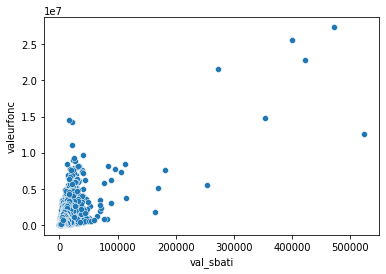

In [ ]:
sns.scatterplot(df_mut_filtered['val_sbati'], df_mut_filtered['valeurfonc'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


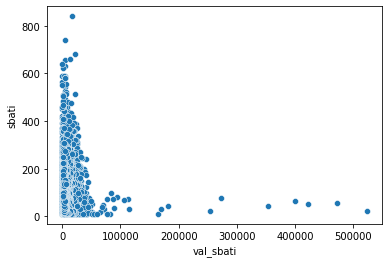

In [ ]:
sns.scatterplot(df_mut_filtered['val_sbati'], df_mut_filtered['sbati'])

In [ ]:
# ratio Less than 300 = Drop
df_mut_filtered[df_mut_filtered.val_sbati < 300]

,idnatmut,valeurfonc,nbdispo,nblot,nbcomm,l_codinsee,nbsection,l_section,nbpar,l_idpar,nbparmut,l_idparmut,nbsuf,sterr,nbvolmut,nblocmut,l_idlocmut,nblocmai,nblocapt,nblocdep,nblocact,nbapt1pp,nbapt2pp,nbapt3pp,nbapt4pp,nbapt5pp,nbmai1pp,nbmai2pp,nbmai3pp,nbmai4pp,nbmai5pp,sbati,sbatmai,sbatapt,sbatact,sapt1pp,sapt2pp,sapt3pp,sapt4pp,sapt5pp,smai1pp,smai2pp,smai3pp,smai4pp,smai5pp,codtypbien,days_from_today,2014,2015,2016,2017,2018,2019,2020,jan,feb,mar,apr,may,jun,jul,7,8,9,10,11,valeurfonc_log,sbati_log,val_sbati
71,1,3000.0,1,1,1,['75102'],1,['AN'],1,75102000AN0135,0.0,None,0.0,0.0,0.0,1.0,['751020007850509_0'],0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0,47.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,832,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.006701,3.871201,63.829787
90,1,8000.0,1,1,1,['75110'],1,['BK'],1,75110000BK0037,0.0,None,0.0,0.0,0.0,1.0,['751100008815720_0'],0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0,33.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,2886,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.987322,3.526361,242.424242
113,1,1460.0,1,1,1,['75110'],1,['BE'],1,75110000BE0100,0.0,None,0.0,0.0,0.0,1.0,['751100008818520_0'],0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,0.0,52.0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,2661,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.286876,3.970292,28.076923
119,1,5000.0,1,1,1,['75115'],1,['DU'],1,75115000DU0002,0.0,None,0.0,0.0,0.0,1.0,['751150008660348_0'],0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,0.0,88.0,0.0,0.0,0.0,0.0,88.0,0.0,0.0,0.0,0.0,0.0,0.0,121,2253,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.517393,4.488636,56.818182
159,1,1300.0,1,1,1,['75112'],1,['EL'],1,75112000EL0045,0.0,None,0.0,0.0,0.0,1.0,['751120008254519_0'],0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,12.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,1694,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.170888,2.564949,108.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618648,1,10000.0,1,1,1,['95210'],1,['AD'],1,95210000AD0743,0.0,None,0.0,0.0,0.0,1.0,['952100010885397_0'],0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,50.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,1025,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.210440,3.931826,200.000000
619716,1,9700.0,1,1,1,['95063'],1,['AL'],1,95063000AL0257,0.0,None,0.0,0.0,0.0,2.0,"['950630011102328_0', '950630011102329_0']",0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,0.0,45.0,0.0,0.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,1742,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.179984,3.828641,215.555556
621860,1,7300.0,1,1,1,['95563'],1,['BK'],1,95563000BK0442,0.0,None,0.0,0.0,0.0,1.0,['955630011334444_0'],0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0.0,53.0,0.0,0.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,2941,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.895767,3.988984,137.735849
624175,1,10000.0,1,2,1,['95197'],1,['AP'],1,95197000AP0416,0.0,None,0.0,0.0,0.0,1.0,['951970011181596_0'],0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,40.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,2070,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9.210440,3.713572,250.000000


In [ ]:
# Drop them
df_mut_filtered = df_mut_filtered[df_mut_filtered.val_sbati > 300]

In [ ]:
# Replacing 0 cases for nblot to nblocmut
lot = df_mut_filtered['nblot'].tolist()
locmut = df_mut_filtered['nblocmut'].tolist()

for i in range(len(lot)):
  if lot[i] == 0:
    lot[i] = locmut[i]
    
df_mut_filtered['new_nblot'] = lot

In [ ]:
# Now we drop the original nblot column
df_mut_filtered.drop('nblot', axis = 1, inplace=True)

In [ ]:
df_mut_filtered.head()

,idnatmut,valeurfonc,nbdispo,nbcomm,l_codinsee,nbsection,l_section,nbpar,l_idpar,nbparmut,l_idparmut,nbsuf,sterr,nbvolmut,nblocmut,l_idlocmut,nblocmai,nblocapt,nblocdep,nblocact,nbapt1pp,nbapt2pp,nbapt3pp,nbapt4pp,nbapt5pp,nbmai1pp,nbmai2pp,nbmai3pp,nbmai4pp,nbmai5pp,sbati,sbatmai,sbatapt,sbatact,sapt1pp,sapt2pp,sapt3pp,sapt4pp,sapt5pp,smai1pp,smai2pp,smai3pp,smai4pp,smai5pp,codtypbien,days_from_today,2014,2015,2016,2017,2018,2019,2020,jan,feb,mar,apr,may,jun,jul,7,8,9,10,11,valeurfonc_log,sbati_log,val_sbati,new_nblot
0,1,650340.0,1,1,['75102'],1,['AI'],1,75102000AI0121,0.0,None,0.0,0.0,0.0,1.0,['751020008079141_0'],0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,0.0,63.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,1413,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.385252,4.158883,10322.857143,4.0
1,1,380000.0,1,1,['75111'],1,['AL'],1,75111000AL0036,0.0,None,0.0,0.0,0.0,1.0,['751110008254520_0'],0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,40.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,1687,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,12.847929,3.713572,9500.000000,2.0
2,1,260000.0,1,1,['75120'],1,['CE'],1,75120000CE0022,0.0,None,0.0,0.0,0.0,1.0,['751200008072727_0'],0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0,33.0,0.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,1399,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.468441,3.526361,7878.787879,2.0
3,1,114000.0,1,1,['75110'],1,['BJ'],1,75110000BJ0114,0.0,None,0.0,0.0,0.0,1.0,['751100008249772_0'],0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,14.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,1583,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.643962,2.708050,8142.857143,2.0
4,1,215000.0,1,1,['75104'],1,['AJ'],1,75104000AJ0120,0.0,None,0.0,0.0,0.0,1.0,['751040008497685_0'],0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,17.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,2173,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.278398,2.890372,12647.058824,1.0


In [ ]:
#import libraries for geolocation 
import geopandas as gp
from shapely.geometry import Polygon

In [ ]:
#load all the parecelles

parcelles_75 = gp.read_file(path + 'cadastre-75-parcelles.json')
parcelles_77 = gp.read_file(path + 'cadastre-77-parcelles.json') 
parcelles_78 = gp.read_file(path + 'cadastre-78-parcelles.json')
parcelles_91 = gp.read_file(path + 'cadastre-91-parcelles.json')
parcelles_92 = gp.read_file(path + 'cadastre-92-parcelles.json')
parcelles_93 = gp.read_file(path + 'cadastre-93-parcelles.json')
parcelles_94 = gp.read_file(path + 'cadastre-94-parcelles.json')
parcelles_95 = gp.read_file(path + 'cadastre-95-parcelles.json'

In [ ]:
#Function that gives back parcelles dataframe with latitude and longitude

def latlong(parcelles):

  c = gp.GeoSeries(parcelles['geometry'])
  parcelles['longitude'] = c.centroid.x
  parcelles['latitude'] = c.centroid.y

  parcelles = parcelles_75.drop(['commune','prefixe','section','numero','contenance','arpente',
  'created','updated','geometry'], axis = 1)

  return parcelles

In [ ]:
parcelles_75 = latlong(parcelles_75)
parcelles_77 = latlong(parcelles_77)
parcelles_78 = latlong(parcelles_78)
parcelles_91 = latlong(parcelles_91)
parcelles_92 = latlong(parcelles_92)
parcelles_93 = latlong(parcelles_93)
parcelles_94 = latlong(parcelles_94)
parcelles_95 = latlong(parcelles_95)

In [ ]:
#concatinating and save file 
df_latlong = pd.concat([parcelles_75,parcelles_77,parcelles_78,parcelles_91,parcelles_92,parcelles_93,parcelles_94,parcelles_95], ignore_index = True)
df_latlong.to_csv("/content/drive/MyDrive/hackathon-data/Geo_location.csv")

In [ ]:
## Join with latlong table
df_latlong = pd.read_csv('/content/drive/MyDrive/hackathon-data/Geo_location.csv')

In [ ]:
df_merge_ll = df_mut_filtered.merge(df_latlong, 'inner', left_on = 'l_idpar', right_on = 'id')

In [ ]:
df_merge_ll = df_merge_ll.drop(['id'], axis = 1)
df_merge_ll.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
df_merge_ll.head()

,idnatmut,valeurfonc,nbdispo,nbcomm,l_codinsee,nbsection,l_section,nbpar,l_idpar,nbparmut,l_idparmut,nbsuf,sterr,nbvolmut,nblocmut,l_idlocmut,nblocmai,nblocapt,nblocdep,nblocact,nbapt1pp,nbapt2pp,nbapt3pp,nbapt4pp,nbapt5pp,nbmai1pp,nbmai2pp,nbmai3pp,nbmai4pp,nbmai5pp,sbati,sbatmai,sbatapt,sbatact,sapt1pp,sapt2pp,sapt3pp,sapt4pp,sapt5pp,smai1pp,smai2pp,smai3pp,smai4pp,smai5pp,codtypbien,days_from_today,2014,2015,2016,2017,2018,2019,2020,jan,feb,mar,apr,may,jun,jul,7,8,9,10,11,valeurfonc_log,sbati_log,val_sbati,new_nblot,longitude,latitude
0,1,650340.0,1,1,['75102'],1,['AI'],1,75102000AI0121,0.0,None,0.0,0.0,0.0,1.0,['751020008079141_0'],0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,0.0,63.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,1413,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.385252,4.158883,10322.857143,4.0,2.347402,48.868229
1,1,740000.0,1,1,['75102'],1,['AI'],1,75102000AI0121,0.0,None,0.0,0.0,0.0,1.0,['751020007849856_0'],0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,0.0,63.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,952,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,13.514407,4.158883,11746.031746,4.0,2.347402,48.868229
2,1,606000.0,1,1,['75102'],1,['AI'],1,75102000AI0121,0.0,None,0.0,0.0,0.0,1.0,['751020008859922_0'],0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,0.0,63.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,2719,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,13.314637,4.158883,9619.047619,4.0,2.347402,48.868229
3,1,208000.0,1,1,['75102'],1,['AI'],1,75102000AI0121,0.0,None,0.0,0.0,0.0,1.0,['751020008298114_0'],0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,22.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,1702,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12.245298,3.135494,9454.545455,2.0,2.347402,48.868229
4,1,485000.0,1,1,['75102'],1,['AI'],1,75102000AI0121,0.0,None,0.0,0.0,0.0,1.0,['751020008497916_0'],0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.0,0.0,65.0,0.0,0.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,2109,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.091906,4.189655,7461.538462,4.0,2.347402,48.868229


In [ ]:
## shortening of zipcodes to first 2 digits
df_merge_ll['zipcode'] = df_merge_ll['l_codinsee'].str[2:4]

In [ ]:
## one hot encoding of categorical features

df_merge_ll = pd.get_dummies(df_merge_ll, columns = ['codtypbien', 'zipcode'])

In [ ]:
df_merge_ll = df_merge_ll.rename(columns={7: "aug", 8: "sep", 9: "oct", 10: "nov", 11: "dec"})

In [ ]:
# drop: nbcomm, l_codinsee, nbsection, nbpar, l_idpar, nbparmut, l_idparmut, nbvolmut, l_idlocmut

df_merge_ll.drop(['nbcomm', 'l_codinsee', "nbsection", "nbpar", 
                  "l_idpar", "nbparmut", "l_idparmut", "nbvolmut", "l_idlocmut"], axis = 1,
                 inplace=True)


In [ ]:
# MinMax Scale lat-long

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_merge_ll[["longitude_minmax", "latitude_minmax"]] = scaler.fit_transform(df_merge_ll[["longitude", "latitude"]])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


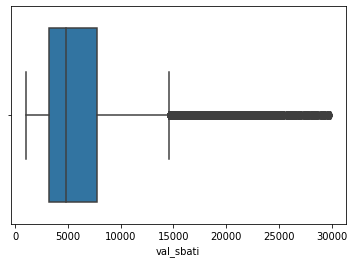

In [ ]:
## val_sbati should be < 30000

df_merge_ll = df_merge_ll[df_merge_ll.val_sbati < 30000]

sns.boxplot(df_merge_ll['val_sbati'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


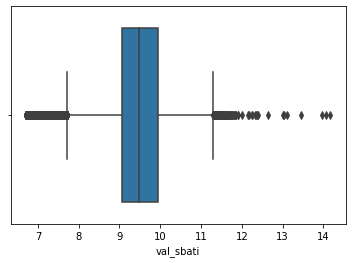

In [ ]:
# Log transform val_sbati
sns.boxplot(np.log(df_merge_ll['val_sbati']) + 1)

df_merge_ll['val_sbati_log'] = np.log(df_merge_ll['val_sbati']+1)

In [ ]:
df_merge_ll

,idnatmut,valeurfonc,nbdispo,l_section,nbsuf,sterr,nblocmut,nblocmai,nblocapt,nblocdep,nblocact,nbapt1pp,nbapt2pp,nbapt3pp,nbapt4pp,nbapt5pp,nbmai1pp,nbmai2pp,nbmai3pp,nbmai4pp,nbmai5pp,sbati,sbatmai,sbatapt,sbatact,sapt1pp,sapt2pp,sapt3pp,sapt4pp,sapt5pp,smai1pp,smai2pp,smai3pp,smai4pp,smai5pp,days_from_today,2014,2015,2016,2017,2018,2019,2020,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,valeurfonc_log,sbati_log,val_sbati,new_nblot,longitude,latitude,codtypbien_121,zipcode_75,zipcode_77,zipcode_78,zipcode_91,zipcode_92,zipcode_93,zipcode_94,zipcode_95,longitude_minmax,latitude_minmax,val_sbati_log
0,1,650340.0,1,['AI'],0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,0.0,63.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1413,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.385252,4.158883,10322.857143,4.0,2.347402,48.868229,1,1,0,0,0,0,0,0,0,0.444091,0.683741,9.242213
1,1,740000.0,1,['AI'],0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,0.0,63.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,952,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,13.514407,4.158883,11746.031746,4.0,2.347402,48.868229,1,1,0,0,0,0,0,0,0,0.444091,0.683741,9.371356
2,1,606000.0,1,['AI'],0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,0.0,63.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2719,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,13.314637,4.158883,9619.047619,4.0,2.347402,48.868229,1,1,0,0,0,0,0,0,0,0.444091,0.683741,9.171604
3,1,208000.0,1,['AI'],0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,22.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1702,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12.245298,3.135494,9454.545455,2.0,2.347402,48.868229,1,1,0,0,0,0,0,0,0,0.444091,0.683741,9.154357
4,1,485000.0,1,['AI'],0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.0,0.0,65.0,0.0,0.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2109,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.091906,4.189655,7461.538462,4.0,2.347402,48.868229,1,1,0,0,0,0,0,0,0,0.444091,0.683741,8.917651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606588,1,78000.0,1,['AK'],0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,21.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,636,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.264477,3.091042,3714.285714,2.0,2.100124,49.050077,1,0,0,0,0,0,0,0,1,0.316458,0.853823,8.220211
606589,1,72000.0,1,['BH'],0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,0.0,37.0,0.0,0.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2822,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.184435,3.637586,1945.945946,3.0,2.089063,49.045942,1,0,0,0,0,0,0,0,1,0.310750,0.849956,7.574017
606590,1,265500.0,1,['0E'],0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,101.0,0.0,0.0,0.0,0.0,101.0,0.0,0.0,0.0,0.0,0.0,0.0,1031,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.489374,4.624973,2628.712871,2.0,2.270130,49.116208,1,0,0,0,0,0,0,0,1,0.404207,0.915676,7.874630
606591,1,230000.0,1,['AC'],0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,67.0,0.0,67.0,0.0,0.0,0.0,0.0,67.0,0.0,0.0,0.0,0.0,0.0,0.0,2026,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,12.345839,4.219508,3432.835821,2.0,2.350633,48.990512,1,0,0,0,0,0,0,0,1,0.445759,0.798112,8.141433


In [ ]:
## sbati^2

df_merge_ll['sbati_2'] = (df_merge_ll['sbati'])**2
df_merge_ll['sbati_log_2'] = (df_merge_ll['sbati_log'])**2


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


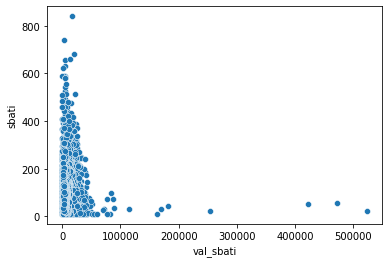

In [ ]:
sns.scatterplot( df_merge_ll['val_sbati'], df_merge_ll['sbati'])

In [ ]:
## remove val_sbati < 1000
df_merge_ll = df_merge_ll[df_merge_ll.val_sbati > 1000]

In [ ]:
# drop unnecessary columns
df_merge_ll.drop(['nbmai1pp', 'nbmai2pp', 'nbmai3pp', 'nbmai4pp', 'nbmai5pp', 'sbatmai', 'sbatapt', 'sbatact', 'sapt1pp', 'sapt2pp',
       'sapt3pp', 'sapt4pp', 'sapt5pp', 'smai1pp', 'smai2pp', 'smai3pp',
       'smai4pp', 'smai5pp'], axis = 1, inplace=True)

In [ ]:
df_merge_ll.sample(5)

In [ ]:
df_merge_ll.to_csv('/content/drive/MyDrive/hackathon-data/mutations_processed_joined_v6.csv')